Я работал в Google Colab. Запустим следующую клетку, чтобы получить доступ к датасету.


In [2]:
### read data
from google.colab import drive        # in colab
drive.mount('/content/drive')         # in colab

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### import

import os
os.chdir("./drive/My Drive/cigarette_butt_segmentation/notebooks")  # in colab
os.chdir("..")

In [0]:
### import


import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

In [44]:
print(os.path.abspath('.'))

/content/drive/My Drive/cigarette_butt_segmentation


In [45]:
### read data
!unzip 'cig_butts/cig_butts.zip' -d 'data'

Archive:  cig_butts/cig_butts.zip
replace data/cig_butts/val/images/00000001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
### important constants

path_train = "data/cig_butts/train"
path_val = "data/cig_butts/val"
dir_img = "data/cig_butts/train/images"

annotations_train = json.load(open(f"{path_train}/coco_annotations.json", "r"))
annotations_val= json.load(open(f"{path_val}/coco_annotations.json", "r"))

Посмотрим на тренировочные данные. Отметим, что данные в train имеют расширение .jpg, а данные в val - расширение .png.


1405


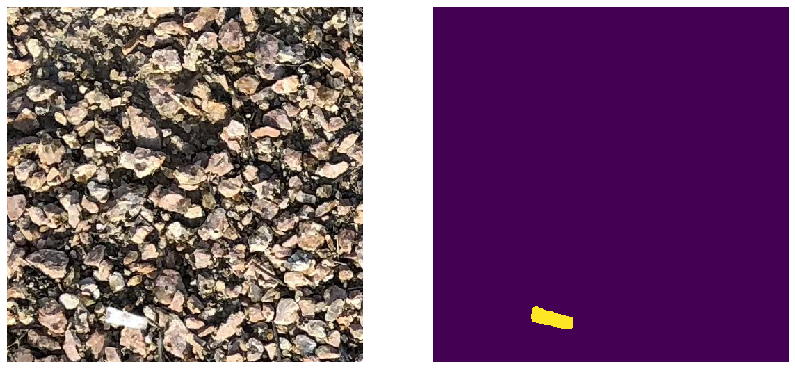

In [5]:
### getting_started.py

images = os.listdir(f"{path_train}/images")
img_id = int(np.random.choice(images).split(".")[0])
print(img_id)

img = np.array(Image.open(f"{dir_img}/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations_train)
show_img_with_mask(img, mask)

Воспользуемся готовой реализацией Unet для Pytorch. Используемая сеть несколько отличается от описанной в оригинальной статье: она использует ненулевые паддинги и batchnorm. Модель написана в файлах lib/unet/unet_parts.py, lib/unet/unet_model.py.

Функция train_net из lib/train.py используется для обучения сети. Важную роль играет также файл lib/dataset.py, в котором описан препроцессинг данных, который проводится перед началом обучения.


In [6]:
### train net
net_1 = UNet(n_channels = 3, n_classes = 1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_1 = net_1.to(device)

n_epochs = 3

scores_val = train_net(net_1, device, batch_size = 1, lr = 0.0003, epochs = n_epochs, save_cp = False, step_size=1, gamma=0.33, pos_weight=65)



Epoch 3/3: 100%|██████████| 2000/2000 [02:01<00:00, 16.42img/s, loss (batch)=0.0451]


Вычислим метрику Dice coefficient на валидационном датасете.

In [7]:
### metric on val

paths_to_imgs = sorted(glob("data/cig_butts/val/images/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]

pred_val = [predict_img(net_1, Image.open(f"{path_val}/images/{img_id:08}.png"), device, out_threshold = 0.5) for img_id in sorted(img_ids)]
true_val = [get_mask(img_id,  annotations_val) for img_id in sorted(img_ids)]

get_dice(true_val, pred_val)

0.5431670870714427

График зависимости dice coefficient на валидации от номера эпохи. Он не очень информативен, поскольку обучение длилось всего 3 эпохи.
Я считал метрику на валидации по два раза за одну эпоху.



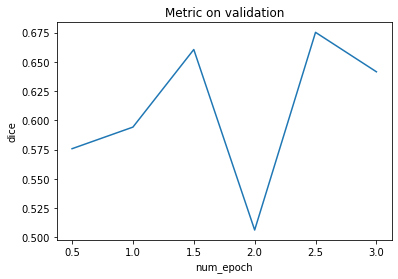

In [8]:
### metrics on val
num_epochs = [0.5*(i + 1)  for i in range(2*n_epochs)]
plt.plot(num_epochs, scores_val)

plt.ylabel('dice')
plt.xlabel('num_epoch')
plt.title('Metric on validation')

plt.show()

Примеры работы обученной сети на картинке из train и val датасетов. Здесь используется функция predict_img из lib/predict.py


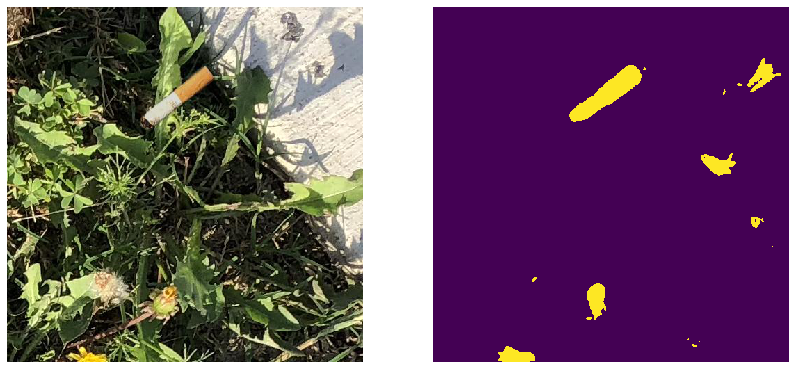

In [43]:
### example train
img_id = 1055
image = Image.open(f"{dir_img}/{img_id:08}.jpg")
pred_mask = predict_img(net_1, image, device, out_threshold = 0.5)


image = np.array(image)
show_img_with_mask(image, pred_mask)


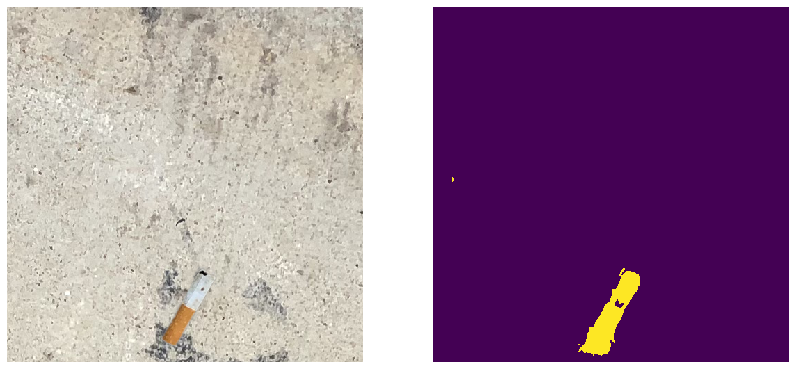

In [34]:
### example val
img_id = 111
image = Image.open(f"{path_val}/images/{img_id:08}.png")
pred_mask = predict_img(net_1, image, device, out_threshold = 0.5)


image = np.array(image)
show_img_with_mask(image, pred_mask)

Создадим .html файл и папку example с результатами работы на тестовых данных.


In [0]:
### results test

path_test = 'data/cig_butts/real_test'
paths_to_imgs = sorted(glob("data/cig_butts/real_test/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]

pred_masks = [predict_img(net_1, Image.open(f"{path_test}/{img_id:04}.JPG"), device, out_threshold = 0.5) for img_id in sorted(img_ids)]
_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

Создадим файл pred_val.csv с результатами на валидационном датасете.


In [0]:
### results val

#annotations_val = json.load(open(f"data/cig_butts/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("data/cig_butts/val/images/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
encoded_masks = [encode_rle(predict_img(net_1, Image.open(f"{path_val}/images/{img_id:08}.png"), device, out_threshold = 0.5)) for img_id in sorted(img_ids)]


In [0]:
### results val

dict = {'img_id': img_ids, 'rle_mask': encoded_masks}
df = pd.DataFrame(dict) 
      
    
df.to_csv("data/pred_val_template.csv", index=False)

In [25]:
### results val

pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,14623 2 15135 3 15647 3 16159 3 16671 3 17183 ...
1,1,89761 6 90268 15 90779 18 91290 19 91802 18 92...
2,2,12146 3 12658 3 13170 2 32817 2 33328 3 33840 ...
3,3,17 2 528 10 693 1 701 7 863 4 875 3 1033 3 103...
4,4,41482 1 41993 1 42501 1 43011 3 43523 2 45069 ...
